In [1]:
import pandas as pd
import numpy as np
import sys
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization,MaxPool1D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from datetime import timedelta
from datetime import datetime
import cv2
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings("ignore")

# 1. Read Data

In [2]:
Merge_Label=pd.read_csv('/home/jianhaozhang/Capstone/Merged_Label.csv')

In [3]:
results=pd.read_csv('/home/jianhaozhang/Capstone/Model/model_summary.csv')

In [4]:
len(Merge_Label)

74357

# 2. Clean Data 

## Drop Unknown and collision label 

In [5]:
Merge_Label=Merge_Label[~Merge_Label.Label.isin(['Unknown','Collision'])]

In [6]:
Merge_Label.Label=Merge_Label.Label.replace('Flying in the shadow of solar panel','Flying under solar panel')

## Drop unnecessary column 

In [7]:
Merge_Label.columns

Index(['Directory', 'Label', 'day_dir', 'camera_dir', 'video_dir', 'track_dir',
       'directory_x', 'image_file', 'count', 'frame', 'x', 'y', 'speed',
       'area', 'id', 'directory_y', 'bird', 'cable', 'panel', 'plant', 'car',
       'human', 'other_animal', 'insect', 'aircraft', 'other', 'unknown',
       'fly_over_above', 'fly_over_reflection', 'fly_through',
       'perch_on_panel', 'land_on_ground', 'perch_in_background', 'collision',
       'uncertain', 'image_count', 'obj_id', 'obj_cat', 'obj_cat_binary',
       'activity_cat', 'ttv_split'],
      dtype='object')

In [8]:
Merge_Label=Merge_Label[['Directory', 'Label', 'x', 'y', 'speed','area','obj_id','frame','image_count']]

In [9]:
Merge_Label.head()

,Directory,Label,x,y,speed,area,obj_id,frame,image_count
0,/project2/msca/projects/AvianSolar/ImageDatase...,Flying with solar panel,832,1134,66.79106,12769,40273,2184,28.0
1,/project2/msca/projects/AvianSolar/ImageDatase...,Flying with solar panel,1692,1330,89.06198,13447,40273,2196,28.0
2,/project2/msca/projects/AvianSolar/ImageDatase...,Flying under solar panel,2988,1787,147.78356,13340,40273,2207,28.0
3,/project2/msca/projects/AvianSolar/ImageDatase...,Flying over reflection,1598,1310,84.22580,13221,40273,2195,28.0
4,/project2/msca/projects/AvianSolar/ImageDatase...,Flying under solar panel,3149,1856,161.16776,12656,40273,2208,28.0


# 3. Create different group labels

## Flying vs. Non-Flying 

In [9]:
group1=Merge_Label.copy()

In [10]:
group1.Label=group1.Label.replace('Flying over sky','Flying')
group1.Label=group1.Label.replace('Flying over other backgrounds','Flying')
group1.Label=group1.Label.replace('Flying with solar panel','Flying')
group1.Label=group1.Label.replace('Flying over reflection','Flying')
group1.Label=group1.Label.replace('Sit on panel','Non-Flying')
group1.Label=group1.Label.replace('Flying just above ground','Flying')
group1.Label=group1.Label.replace('Flying under solar panel','Flying')
group1.Label=group1.Label.replace('Flying with shadow on the ground','Flying')
group1.Label=group1.Label.replace('Sit in background','Non-Flying')
group1.Label=group1.Label.replace('Walking on the ground','Non-Flying')
group1.Label=group1.Label.replace('About to Perch','Non-Flying')
group1.Label=group1.Label.replace('Sit on the ground','Non-Flying')
group1.Label=group1.Label.replace('Walking on the panel','Non-Flying')

In [19]:
group1.Label.value_counts()

Flying        70379
Non-Flying     3632
Name: Label, dtype: int64

In [21]:
label1=group1[group1.Label=='Flying']
label2=group1[group1.Label=='Non-Flying']

In [22]:
under_label1=np.random.choice(label1.Directory,3632,replace=False)

In [23]:
new_label1=label1[label1.Directory.isin(under_label1)]

In [24]:
group1=pd.concat([new_label1,label2],ignore_index=True)

In [25]:
group1.Label.value_counts()

Non-Flying    3632
Flying        3632
Name: Label, dtype: int64

## panel in frame vs. no panel  

In [11]:
group2=Merge_Label.copy()

In [12]:
group2.Label=group2.Label.replace('Flying over sky','No Panel')
group2.Label=group2.Label.replace('Flying over other backgrounds','No Panel')
group2.Label=group2.Label.replace('Flying with solar panel','Panel')
group2.Label=group2.Label.replace('Flying over reflection','Panel')
group2.Label=group2.Label.replace('Sit on panel','Panel')
group2.Label=group2.Label.replace('Flying just above ground','No Panel')
group2.Label=group2.Label.replace('Flying under solar panel','Panel')
group2.Label=group2.Label.replace('Flying with shadow on the ground','No Panel')
group2.Label=group2.Label.replace('Sit in background','No Panel')
group2.Label=group2.Label.replace('Walking on the ground','No Panel')
group2.Label=group2.Label.replace('About to Perch','Panel')
group2.Label=group2.Label.replace('Sit on the ground','No Panel')
group2.Label=group2.Label.replace('Walking on the panel','Panel')

In [22]:
group2.Label.value_counts()

No Panel    50432
Panel       23579
Name: Label, dtype: int64

In [29]:
label1=group2[group2.Label=='No Panel']
label2=group2[group2.Label=='Panel']

In [30]:
under_label1=np.random.choice(label1.Directory,7000,replace=False)
under_label2=np.random.choice(label2.Directory,7000,replace=False)

In [31]:
new_label1=label1[label1.Directory.isin(under_label1)]
new_label2=label2[label2.Directory.isin(under_label2)]

In [32]:
group2=pd.concat([new_label1,new_label2],ignore_index=True)

In [33]:
group2.Label.value_counts()

No Panel    7000
Panel       7000
Name: Label, dtype: int64

## Background vs. panel vs. ground

In [13]:
group3=Merge_Label.copy()

In [14]:
group3.Label=group3.Label.replace('Flying over sky','Background')
group3.Label=group3.Label.replace('Flying over other backgrounds','Background')
group3.Label=group3.Label.replace('Flying with solar panel','Panel')
group3.Label=group3.Label.replace('Flying over reflection','Panel')
group3.Label=group3.Label.replace('Sit on panel','Panel')
group3.Label=group3.Label.replace('Flying just above ground','Ground')
group3.Label=group3.Label.replace('Flying under solar panel','Panel')
group3.Label=group3.Label.replace('Flying with shadow on the ground','Ground')
group3.Label=group3.Label.replace('Sit in background','Background')
group3.Label=group3.Label.replace('Walking on the ground','Ground')
group3.Label=group3.Label.replace('About to Perch','Panel')
group3.Label=group3.Label.replace('Sit on the ground','Ground')
group3.Label=group3.Label.replace('Walking on the panel','Panel')

In [25]:
group3.Label.value_counts()

Background    47501
Panel         23579
Ground         2931
Name: Label, dtype: int64

In [37]:
label1=group3[group3.Label=='Background']
label2=group3[group3.Label=='Panel']
label3=group3[group3.Label=='Ground']

In [38]:
under_label1=np.random.choice(label1.Directory,2931,replace=False)
under_label2=np.random.choice(label2.Directory,2931,replace=False)

In [39]:
new_label1=label1[label1.Directory.isin(under_label1)]
new_label2=label2[label2.Directory.isin(under_label2)]

In [40]:
group3=pd.concat([new_label1,new_label2,label3],ignore_index=True)

In [41]:
group3.Label.value_counts()

Background    2931
Ground        2931
Panel         2931
Name: Label, dtype: int64

## Background vs. Fly with solar panel vs. Interaction vs. ground 

In [15]:
group4=Merge_Label.copy()

In [16]:
group4.Label=group4.Label.replace('Flying over sky','Background')
group4.Label=group4.Label.replace('Flying over other backgrounds','Background')
group4.Label=group4.Label.replace('Flying with solar panel','Flying Panel')
group4.Label=group4.Label.replace('Flying over reflection','Flying Panel')
group4.Label=group4.Label.replace('Sit on panel','Interact Panel')
group4.Label=group4.Label.replace('Flying just above ground','Ground')
group4.Label=group4.Label.replace('Flying under solar panel','Interact Panel')
group4.Label=group4.Label.replace('Flying with shadow on the ground','Ground')
group4.Label=group4.Label.replace('Sit in background','Background')
group4.Label=group4.Label.replace('Walking on the ground','Ground')
group4.Label=group4.Label.replace('About to Perch','Interact Panel')
group4.Label=group4.Label.replace('Sit on the ground','Ground')
group4.Label=group4.Label.replace('Walking on the panel','Interact Panel')

In [28]:
group4.Label.value_counts()

Background        47501
Flying Panel      19987
Interact Panel     3592
Ground             2931
Name: Label, dtype: int64

In [45]:
label1=group4[group4.Label=='Background']
label2=group4[group4.Label=='Flying Panel']
label3=group4[group4.Label=='Interact Panel']
label4=group4[group4.Label=='Ground']

In [46]:
under_label1=np.random.choice(label1.Directory,3592,replace=False)
under_label2=np.random.choice(label2.Directory,3592,replace=False)

In [47]:
new_label1=label1[label1.Directory.isin(under_label1)]
new_label2=label2[label2.Directory.isin(under_label2)]

In [48]:
group4=pd.concat([new_label1,new_label2,label3,label4],ignore_index=True)

In [49]:
group4.Label.value_counts()

Background        3592
Interact Panel    3592
Flying Panel      3592
Ground            2931
Name: Label, dtype: int64

## Full label 

In [10]:
group6=Merge_Label.copy()

In [11]:
group6.Label=group6.Label.replace('Walking on the ground','Sit on the ground')
group6.Label=group6.Label.replace('About to Perch','Sit on panel')
group6.Label=group6.Label.replace('Walking on the panel','Sit on panel')
group6.Label=group6.Label.replace('Flying just above ground','Flying with ground')
group6.Label=group6.Label.replace('Flying with shadow on the ground','Flying with ground')

In [12]:
group6.Label.value_counts()

Flying over sky                  34080
Flying over other backgrounds    12382
Flying with solar panel          10449
Flying over reflection            9538
Flying with ground                2541
Sit on panel                      2203
Flying under solar panel          1389
Sit in background                 1039
Sit on the ground                  390
Name: Label, dtype: int64

In [13]:
label1=group6[group6.Label=='Flying over sky']
label2=group6[group6.Label=='Flying over other backgrounds']
label3=group6[group6.Label=='Flying with solar panel']
label4=group6[group6.Label=='Flying over reflection']
label5=group6[group6.Label=='Flying with ground']
label6=group6[group6.Label=='Sit on panel']
label7=group6[group6.Label=='Flying under solar panel']
label8=group6[group6.Label=='Sit in background']
label9=group6[group6.Label=='Sit on the ground']

In [14]:
under_label1=np.random.choice(label1.Directory,3000,replace=False)
under_label2=np.random.choice(label2.Directory,3000,replace=False)
under_label3=np.random.choice(label3.Directory,3000,replace=False)
under_label4=np.random.choice(label4.Directory,3000,replace=False)

In [15]:
new_label1=label1[label1.Directory.isin(under_label1)]
new_label2=label2[label2.Directory.isin(under_label2)]
new_label3=label3[label3.Directory.isin(under_label3)]
new_label4=label4[label4.Directory.isin(under_label4)]

In [16]:
group6=pd.concat([new_label1,new_label2,new_label3,new_label4,label5,label6,label7,label8,label9],ignore_index=True)

In [17]:
group6.Label.value_counts()

Flying over sky                  3000
Flying over other backgrounds    3000
Flying with solar panel          3000
Flying over reflection           3000
Flying with ground               2541
Sit on panel                     2203
Flying under solar panel         1389
Sit in background                1039
Sit on the ground                 390
Name: Label, dtype: int64

# 4. Feature Engineering

## Train/Test/Val Split 

In [18]:
def train_test_val_split(data):
    
    track_list=list(pd.unique(data.obj_id))
    train_val_tmp,test_tmp=train_test_split(track_list,test_size=0.15,train_size=0.85,random_state=66)
        #train_val split
    train_tmp,val_tmp= train_test_split(train_val_tmp,test_size =0.1,train_size =0.9,random_state=66)
    
    train=data[data.obj_id.isin(train_tmp)]
    test=data[data.obj_id.isin(test_tmp)]
    val=data[data.obj_id.isin(val_tmp)]
    
    return train,test,val

## Label Encoding

In [19]:
def label_encoding(train,test,val):
    num_class = len(pd.unique(train.Label))
    
    #label encoder
    label_encoder = LabelEncoder()
    train_label_encoded = label_encoder.fit_transform(np.ravel(train.Label, order='C'))
    val_label_encoded = label_encoder.transform(np.ravel(val.Label, order='C'))
    test_label_encoded = label_encoder.transform(np.ravel(test.Label, order='C'))
    
    train['label_encode']=list(train_label_encoded)
    val['label_encode']=list(val_label_encoded)
    test['label_encode']=list(test_label_encoded)
    
    #convert to class vector
    train_label_vec=keras.utils.to_categorical(train_label_encoded,num_class)
    val_label_vec=keras.utils.to_categorical(val_label_encoded,num_class)
    test_label_vec=keras.utils.to_categorical(test_label_encoded,num_class)
    
    train['label_vec']=list(train_label_vec)
    val['label_vec']=list(val_label_vec)
    test['label_vec']=list(test_label_vec)
    
    
    return train,test,val

## Normalize Metadata 

In [20]:
def normalize(train,test,val):
    
    sc=StandardScaler()
    train[['x','y','speed','area']]=sc.fit_transform(train[['x','y','speed','area']])
    test[['x','y','speed','area']]=sc.transform(test[['x','y','speed','area']])
    val[['x','y','speed','area']]=sc.transform(val[['x','y','speed','area']])
    
    return train,test,val

## Preprocessing: put all together 

In [21]:
def preprocessing(data):
    train,test,val=train_test_val_split(data)
    train,test,val=label_encoding(train,test,val)
    train,test,val=normalize(train,test,val)
    
    return train,test,val

# 5. Data Pipeline

In [22]:
def process_img(directory):
    #read image
    img = tf.io.read_file(directory)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    img = tf.image.resize_with_pad(img,224,224) #resize by 224 

    return img

In [23]:
def get_label(label):
    return tf.convert_to_tensor(label)

In [24]:
def get_metadata(metadata):
    return tf.convert_to_tensor(metadata,dtype=tf.float64)

In [25]:
batch_size=256
def batch_processing(df):
    img_dir=list(df.Directory.values)
    label_vec=list(df.label_vec.values)
    meta_list=list(df[['x','y','speed','area']].to_numpy())
    
    
#     img_data=tf.data.Dataset.from_tensor_slices(train.Directory.values).map(lambda x:tf.py_function(func=process_img,
#           inp=[x],Tout=tf.float32))
    img_data=tf.data.Dataset.from_tensor_slices(img_dir).map(lambda x: process_img(x))
    img_data=img_data.map(lambda x: keras.applications.resnet50.preprocess_input(x))
    label_data=tf.data.Dataset.from_tensor_slices(label_vec).map(lambda x: get_label(x))
    meta_data=tf.data.Dataset.from_tensor_slices(meta_list).map(lambda x: get_metadata(x)) 
    
    combined_input=tf.data.Dataset.zip((img_data,meta_data))
    #combined_data=tf.data.Dataset.zip((img_data,label_data))
    combined_data=tf.data.Dataset.zip((combined_input,label_data))
    combined_data=combined_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return combined_data

In [26]:
def data_generator(data):
    train,test,val=preprocessing(data)
    
    train_data=batch_processing(train)
    test_data=batch_processing(test)
    val_data=batch_processing(val)
    
    return train_data,test_data,val_data

## Generate data 

In [62]:
train_data1,test_data1,val_data1=data_generator(group1)
train_data2,test_data2,val_data2=data_generator(group2)
train_data3,test_data3,val_data3=data_generator(group3)
train_data4,test_data4,val_data4=data_generator(group4)
train_data6,test_data6,val_data6=data_generator(group6)

# 6. Building Model

In [73]:
def draw_learning_curve(history,path,keys=['categorical_accuracy','loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        plt.xlabel('Epoch')
        plt.legend(['train', 'val'], loc='best')
    plt.savefig(path+'/model_learning_curve.png')
    plt.show()

In [74]:
def generate_model(df):
    resnet=tf.keras.applications.ResNet50(
            weights="imagenet", 
            input_shape=(224,224,3),
            include_top=False)

    img_inputs = keras.Input(shape=(224, 224, 3))
    first = resnet(img_inputs, training=False)
    first = Dropout(.5)(first)
    first = keras.layers.GlobalAveragePooling2D()(first)
    #first = Flatten()(first)

    meta_inputs= keras.Input(shape=(4,1))
    second = Dense(16,activation= "relu")(meta_inputs)
    second = Dropout(.3)(second)
    second = Dense(32,activation= "relu")(second)
    second = Dropout(.3)(second)
    second = Flatten()(second)

    combined = keras.layers.concatenate([first,second])
    combined = Dense(128, activation= "relu")(combined)
    combined = Dropout(.3)(combined)

    outputs = Dense(len(pd.unique(df.Label)), activation='softmax')(combined)

    #optimizer = keras.optimizers.RMSprop(lr=2e-5) #Try Adam, different learning rate 
    model = keras.Model(inputs=[img_inputs,meta_inputs], outputs=[outputs])
    model.compile(optimizer = keras.optimizers.RMSprop(lr=1e-6),#tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='CategoricalCrossentropy', 
                  metrics=[keras.metrics.CategoricalAccuracy()])#keras.metrics.CategoricalAccuracy()
    return model

# 7. Training Model 

In [74]:
batch_size=64
epochs=40

model_earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            verbose=1,
                                                            mode='min',
                                                            patience=5,
                                                            restore_best_weights=True)

## Group 1

In [136]:
model1=generate_model(group1)

In [106]:
#keras.utils.plot_model(modela, "my_model_graph.png", show_shapes=True)

In [140]:
checkpoint_filepath = '/home/jianhaozhang/Capstone/Model/Group1'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    verbose=1,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history1 = model1.fit(train_data1, epochs=epochs,batch_size=batch_size,validation_data=val_data1,shuffle=True,
                   callbacks=model_checkpoint_callback)

Epoch 1/40
44/44 [==============================] - 277s 6s/step - loss: 0.5786 - categorical_accuracy: 0.8037 - val_loss: 1.0054 - val_categorical_accuracy: 0.5188

Epoch 00001: val_loss improved from inf to 1.00542, saving model to /home/jianhaozhang/Capstone/Model/Group1
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group1/assets
Epoch 2/40
44/44 [==============================] - 31s 706ms/step - loss: 0.4518 - categorical_accuracy: 0.8058 - val_loss: 0.7265 - val_categorical_accuracy: 0.5516

Epoch 00002: val_loss improved from 1.00542 to 0.72648, saving model to /home/jianhaozhang/Capstone/Model/Group1
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group1/assets
Epoch 3/40
44/44 [==============================] - 31s 705ms/step - loss: 0.5044 - categorical_accuracy: 0.7526 - val_loss: 0.6294 - val_categorical_accuracy: 0.5941

Epoch 00003: val_loss improved from 0.72648 to 0.62939, saving model to /home/jianhaozhang/Capstone/Model/Grou

INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group1/assets
Epoch 24/40
44/44 [==============================] - 31s 705ms/step - loss: 0.2277 - categorical_accuracy: 0.8961 - val_loss: 0.3662 - val_categorical_accuracy: 0.8331

Epoch 00024: val_loss improved from 0.36804 to 0.36617, saving model to /home/jianhaozhang/Capstone/Model/Group1
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group1/assets
Epoch 25/40
44/44 [==============================] - 31s 706ms/step - loss: 0.2184 - categorical_accuracy: 0.9029 - val_loss: 0.3647 - val_categorical_accuracy: 0.8347

Epoch 00025: val_loss improved from 0.36617 to 0.36474, saving model to /home/jianhaozhang/Capstone/Model/Group1
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group1/assets
Epoch 26/40
44/44 [==============================] - 31s 706ms/step - loss: 0.2145 - categorical_accuracy: 0.9065 - val_loss: 0.3625 - val_categorical_accuracy: 0.8363

Epoch 00026: val_l

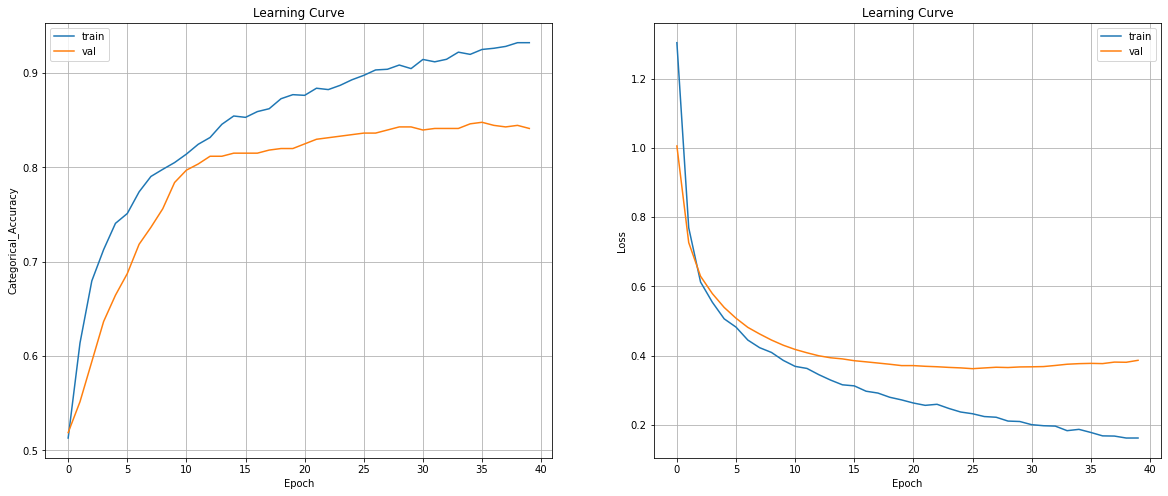

In [143]:
draw_learning_curve(history1,checkpoint_filepath)

In [145]:
#model 1 summarized results
train_loss1, train_acc1 = model1.evaluate(train_data1)
val_loss1, val_acc1 = model1.evaluate(val_data1)
test_loss1, test_acc1 = model1.evaluate(test_data1)

Model1 = "Group1"
results = pd.DataFrame(columns = ['Model', 'Train-Loss', 'Train-Accuracy','Val-Loss','Val-Accuracy','Test-Loss','Test-Accuracy'])
row1 = [Model1, train_loss1, train_acc1*100,val_loss1,val_acc1*100,test_loss1, test_acc1*100]
results = results.append(pd.DataFrame([row1], columns=results.columns), ignore_index=True)

9/9 [==============================] - 43s 5s/step - loss: 0.2730 - categorical_accuracy: 0.8844


## Group 2 

In [84]:
model2=generate_model(group2)

In [86]:
checkpoint_filepath = '/home/jianhaozhang/Capstone/Model/Group2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    verbose=1,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history2 = model2.fit(train_data2, epochs=epochs,batch_size=batch_size,validation_data=val_data2,shuffle=True,
                   callbacks=[model_checkpoint_callback,model_earlystop_callback])

Epoch 1/40
84/84 [==============================] - 71s 717ms/step - loss: 0.8471 - categorical_accuracy: 0.5665 - val_loss: 0.7094 - val_categorical_accuracy: 0.6407

Epoch 00001: val_loss improved from inf to 0.70939, saving model to /home/jianhaozhang/Capstone/Model/Group2
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group2/assets
Epoch 2/40
84/84 [==============================] - 59s 706ms/step - loss: 0.5953 - categorical_accuracy: 0.6990 - val_loss: 0.6165 - val_categorical_accuracy: 0.7030

Epoch 00002: val_loss improved from 0.70939 to 0.61653, saving model to /home/jianhaozhang/Capstone/Model/Group2
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group2/assets
Epoch 3/40
84/84 [==============================] - 59s 707ms/step - loss: 0.4627 - categorical_accuracy: 0.7733 - val_loss: 0.5221 - val_categorical_accuracy: 0.7535

Epoch 00003: val_loss improved from 0.61653 to 0.52208, saving model to /home/jianhaozhang/Capstone/Model/Gr

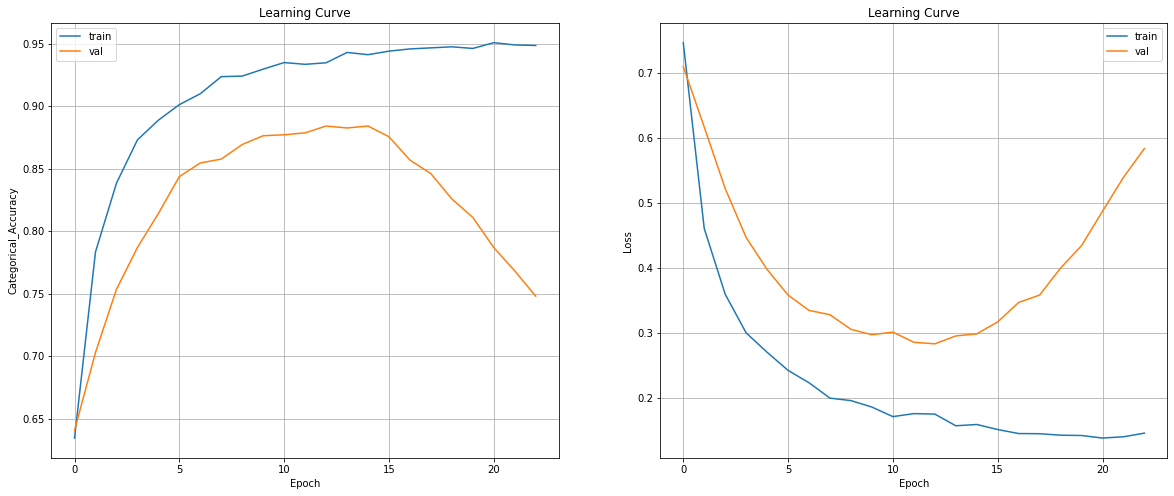

In [88]:
draw_learning_curve(history2,checkpoint_filepath)

In [89]:
#model 2 summarized results
train_loss2, train_acc2 = model2.evaluate(train_data2)
val_loss2, val_acc2 = model2.evaluate(val_data2)
test_loss2, test_acc2 = model2.evaluate(test_data2)

Model2 = "Group2"
row2 = [Model2, train_loss2, train_acc2*100,val_loss2,val_acc2*100,test_loss2, test_acc2*100]
results = results.append(pd.DataFrame([row2], columns=results.columns), ignore_index=True)

17/17 [==============================] - 67s 4s/step - loss: 0.1884 - categorical_accuracy: 0.9284


## Group 3 

In [92]:
model3=generate_model(group3)

In [93]:
checkpoint_filepath = '/home/jianhaozhang/Capstone/Model/Group3'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    verbose=1,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history3 = model3.fit(train_data3, epochs=epochs,batch_size=batch_size,validation_data=val_data3,shuffle=True,
                   callbacks=[model_checkpoint_callback,model_earlystop_callback])

Epoch 1/40
53/53 [==============================] - 249s 5s/step - loss: 1.3743 - categorical_accuracy: 0.3728 - val_loss: 0.9103 - val_categorical_accuracy: 0.5803

Epoch 00001: val_loss improved from inf to 0.91035, saving model to /home/jianhaozhang/Capstone/Model/Group3
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group3/assets
Epoch 2/40
53/53 [==============================] - 38s 708ms/step - loss: 0.8235 - categorical_accuracy: 0.6368 - val_loss: 0.6610 - val_categorical_accuracy: 0.7352

Epoch 00002: val_loss improved from 0.91035 to 0.66103, saving model to /home/jianhaozhang/Capstone/Model/Group3
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group3/assets
Epoch 3/40
53/53 [==============================] - 38s 708ms/step - loss: 0.6188 - categorical_accuracy: 0.7541 - val_loss: 0.5093 - val_categorical_accuracy: 0.8085

Epoch 00003: val_loss improved from 0.66103 to 0.50927, saving model to /home/jianhaozhang/Capstone/Model/Grou

INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group3/assets
Epoch 24/40
53/53 [==============================] - 38s 708ms/step - loss: 0.1648 - categorical_accuracy: 0.9446 - val_loss: 0.1803 - val_categorical_accuracy: 0.9394

Epoch 00024: val_loss improved from 0.18222 to 0.18030, saving model to /home/jianhaozhang/Capstone/Model/Group3
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group3/assets
Epoch 25/40
53/53 [==============================] - 38s 709ms/step - loss: 0.1624 - categorical_accuracy: 0.9473 - val_loss: 0.1792 - val_categorical_accuracy: 0.9394

Epoch 00025: val_loss improved from 0.18030 to 0.17924, saving model to /home/jianhaozhang/Capstone/Model/Group3
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group3/assets
Epoch 26/40
53/53 [==============================] - 38s 709ms/step - loss: 0.1572 - categorical_accuracy: 0.9452 - val_loss: 0.1785 - val_categorical_accuracy: 0.9408

Epoch 00026: val_l

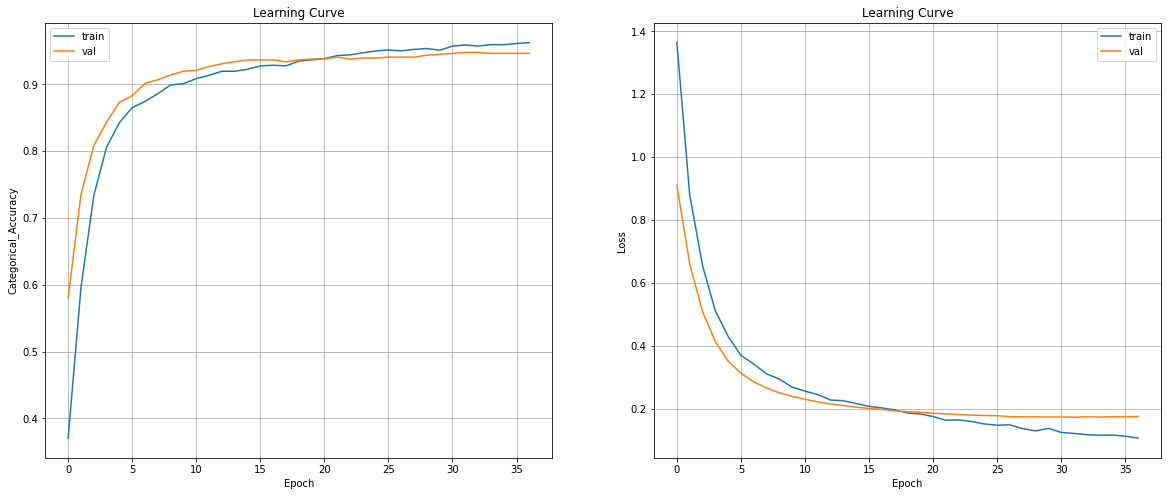

In [94]:
draw_learning_curve(history3,checkpoint_filepath)

In [95]:
#model 3 summarized results
train_loss3, train_acc3 = model3.evaluate(train_data3)
val_loss3, val_acc3 = model3.evaluate(val_data3)
test_loss3, test_acc3 = model3.evaluate(test_data3)

Model3 = "Group3"
row3 = [Model3, train_loss3, train_acc3*100,val_loss3,val_acc3*100,test_loss3, test_acc3*100]
results = results.append(pd.DataFrame([row3], columns=results.columns), ignore_index=True)

11/11 [==============================] - 46s 4s/step - loss: 0.1887 - categorical_accuracy: 0.9470


## Group 4 

In [98]:
model4=generate_model(group4)

In [99]:
checkpoint_filepath = '/home/jianhaozhang/Capstone/Model/Group4'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    verbose=1,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history4 = model4.fit(train_data4, epochs=epochs,batch_size=batch_size,validation_data=val_data4,shuffle=True,
                   callbacks=[model_checkpoint_callback,model_earlystop_callback])

Epoch 1/40
84/84 [==============================] - 350s 4s/step - loss: 1.2347 - categorical_accuracy: 0.5270 - val_loss: 1.1169 - val_categorical_accuracy: 0.5543

Epoch 00001: val_loss improved from inf to 1.11688, saving model to /home/jianhaozhang/Capstone/Model/Group4
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group4/assets
Epoch 2/40
84/84 [==============================] - 59s 706ms/step - loss: 0.9790 - categorical_accuracy: 0.6131 - val_loss: 0.8971 - val_categorical_accuracy: 0.6676

Epoch 00002: val_loss improved from 1.11688 to 0.89710, saving model to /home/jianhaozhang/Capstone/Model/Group4
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group4/assets
Epoch 3/40
84/84 [==============================] - 59s 705ms/step - loss: 0.8565 - categorical_accuracy: 0.6534 - val_loss: 0.7663 - val_categorical_accuracy: 0.7215

Epoch 00003: val_loss improved from 0.89710 to 0.76628, saving model to /home/jianhaozhang/Capstone/Model/Grou

INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group4/assets
Epoch 24/40
84/84 [==============================] - 59s 705ms/step - loss: 0.3552 - categorical_accuracy: 0.8672 - val_loss: 0.3338 - val_categorical_accuracy: 0.8785

Epoch 00024: val_loss improved from 0.33987 to 0.33380, saving model to /home/jianhaozhang/Capstone/Model/Group4
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group4/assets
Epoch 25/40
84/84 [==============================] - 59s 705ms/step - loss: 0.3496 - categorical_accuracy: 0.8722 - val_loss: 0.3322 - val_categorical_accuracy: 0.8767

Epoch 00025: val_loss improved from 0.33380 to 0.33224, saving model to /home/jianhaozhang/Capstone/Model/Group4
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group4/assets
Epoch 26/40
84/84 [==============================] - 59s 705ms/step - loss: 0.3455 - categorical_accuracy: 0.8771 - val_loss: 0.3324 - val_categorical_accuracy: 0.8758

Epoch 00026: val_l

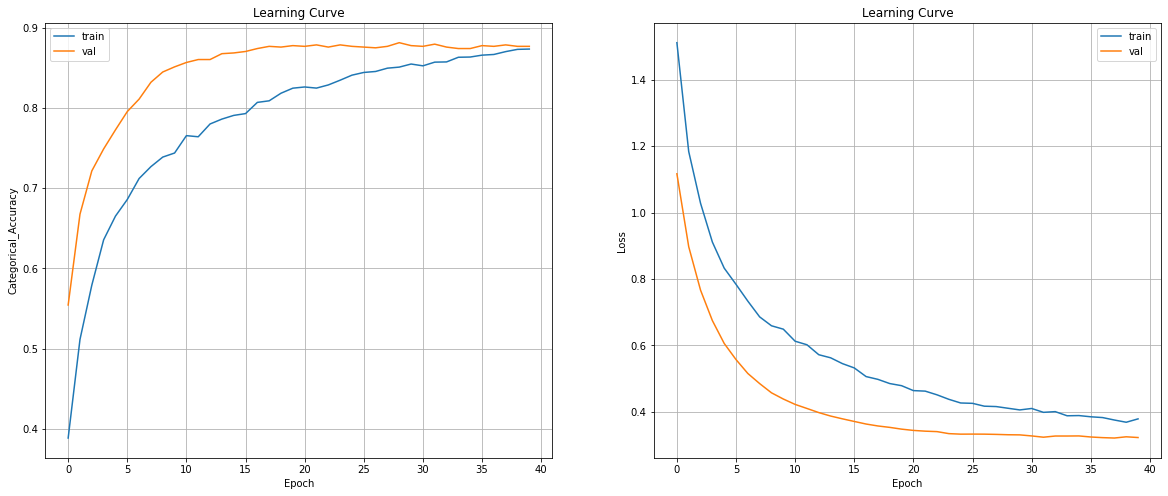

In [100]:
draw_learning_curve(history4,checkpoint_filepath)

In [101]:
#model 4 summarized results
train_loss4, train_acc4 = model4.evaluate(train_data4)
val_loss4, val_acc4 = model4.evaluate(val_data4)
test_loss4, test_acc4 = model4.evaluate(test_data4)

Model4 = "Group4"
row4 = [Model4, train_loss4, train_acc4*100,val_loss4,val_acc4*100,test_loss4, test_acc4*100]
results = results.append(pd.DataFrame([row4], columns=results.columns), ignore_index=True)

16/16 [==============================] - 65s 4s/step - loss: 0.4863 - categorical_accuracy: 0.8165


## Full Label

In [76]:
model6=generate_model(group6)

In [77]:
checkpoint_filepath = '/home/jianhaozhang/Capstone/Model/Group6'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    verbose=1,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history6 = model6.fit(train_data6, epochs=epochs,batch_size=batch_size,validation_data=val_data6,shuffle=True,
                   callbacks=[model_checkpoint_callback,model_earlystop_callback])

Epoch 1/40
106/106 [==============================] - 458s 4s/step - loss: 2.7944 - categorical_accuracy: 0.0625 - val_loss: 2.1923 - val_categorical_accuracy: 0.1388

Epoch 00001: val_loss improved from inf to 2.19228, saving model to /home/jianhaozhang/Capstone/Model/Group6
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group6/assets
Epoch 2/40
106/106 [==============================] - 75s 709ms/step - loss: 2.2521 - categorical_accuracy: 0.1556 - val_loss: 1.9790 - val_categorical_accuracy: 0.2875

Epoch 00002: val_loss improved from 2.19228 to 1.97904, saving model to /home/jianhaozhang/Capstone/Model/Group6
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group6/assets
Epoch 3/40
106/106 [==============================] - 75s 709ms/step - loss: 1.9479 - categorical_accuracy: 0.3076 - val_loss: 1.8219 - val_categorical_accuracy: 0.4115

Epoch 00003: val_loss improved from 1.97904 to 1.82195, saving model to /home/jianhaozhang/Capstone/Mode


Epoch 00023: val_loss improved from 1.14025 to 1.13321, saving model to /home/jianhaozhang/Capstone/Model/Group6
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group6/assets
Epoch 24/40
106/106 [==============================] - 75s 708ms/step - loss: 0.7381 - categorical_accuracy: 0.7515 - val_loss: 1.1277 - val_categorical_accuracy: 0.6763

Epoch 00024: val_loss improved from 1.13321 to 1.12772, saving model to /home/jianhaozhang/Capstone/Model/Group6
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group6/assets
Epoch 25/40
106/106 [==============================] - 75s 708ms/step - loss: 0.7254 - categorical_accuracy: 0.7560 - val_loss: 1.1206 - val_categorical_accuracy: 0.6756

Epoch 00025: val_loss improved from 1.12772 to 1.12056, saving model to /home/jianhaozhang/Capstone/Model/Group6
INFO:tensorflow:Assets written to: /home/jianhaozhang/Capstone/Model/Group6/assets
Epoch 26/40
106/106 [==============================] - 75s 709ms/step

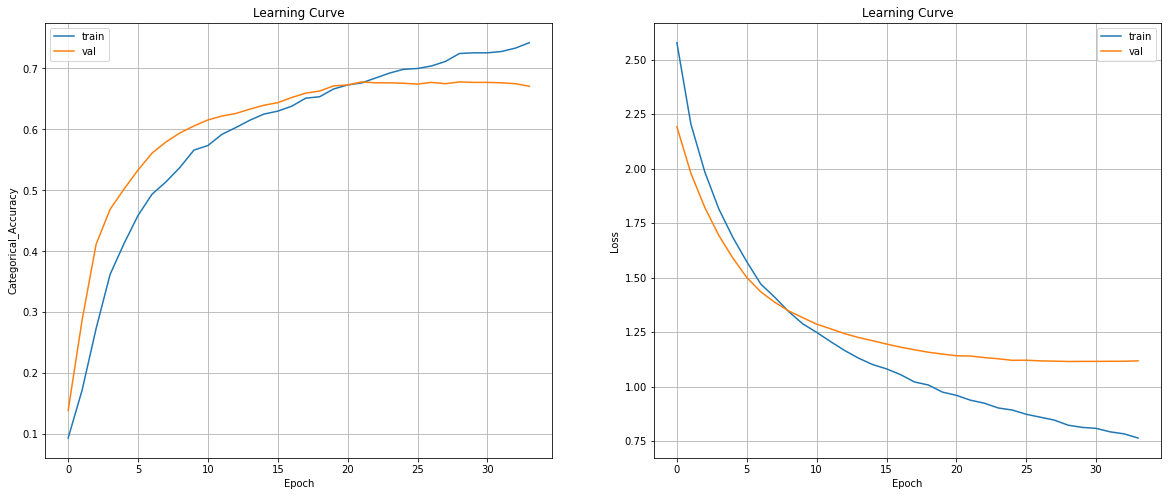

In [78]:
draw_learning_curve(history6,checkpoint_filepath)

In [79]:
#model 6 summarized results
train_loss6, train_acc6 = model6.evaluate(train_data6)
val_loss6, val_acc6 = model6.evaluate(val_data6)
test_loss6, test_acc6 = model6.evaluate(test_data6)

Model6 = "Group6"
row6 = [Model6, train_loss6, train_acc6*100,val_loss6,val_acc6*100,test_loss6, test_acc6*100]
results = results.append(pd.DataFrame([row6], columns=results.columns), ignore_index=True)

21/21 [==============================] - 75s 3s/step - loss: 0.8364 - categorical_accuracy: 0.7138


# 8. Evaluate model on the entire dataset

## Refine data preprocessing 

In [16]:
def label_encoding(data):
    num_class = len(pd.unique(data.Label))
    
    #label encoder
    label_encoder = LabelEncoder()
    data_encoded = label_encoder.fit_transform(np.ravel(data.Label, order='C'))

    #convert to class vector
    data_label_vec=keras.utils.to_categorical(data_encoded,num_class)
    
    data['label_encode']=list(data_encoded)
    data['label_vec']=list(data_label_vec)
    
    
    return data

In [17]:
def normalize(data):
    
    sc=StandardScaler()
    data[['x','y','speed','area']]=sc.fit_transform(data[['x','y','speed','area']])
    
    
    return data

In [18]:
def preprocessing(data):

    data=label_encoding(data)
    data=normalize(data)
    
    return data

In [19]:
def data_generator(data):   
    test_data=batch_processing(data)
    
    return test_data

## Group1 

In [27]:
model1=keras.models.load_model('/home/jianhaozhang/Capstone/Model/Group1')
pre_group1=preprocessing(group1)
y_true1=list(pre_group1.label_encode)
test1=data_generator(pre_group1)

In [28]:
axis_label1=['Flying','Non-Flying']

In [29]:
y_pred1=model1.predict(test1)

In [30]:
y_pred1_label=np.argmax(y_pred1, axis=1)

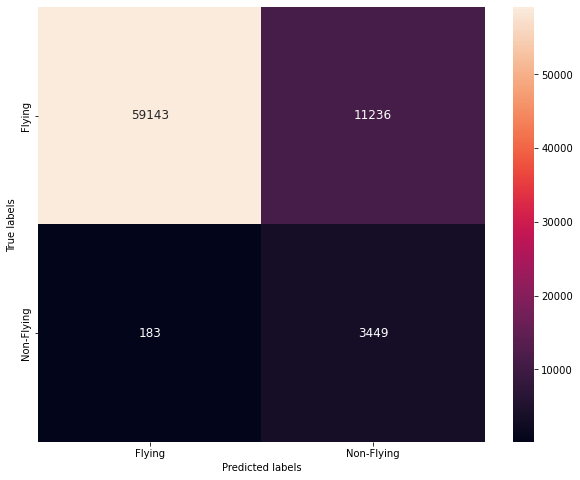

In [34]:
cm1=confusion_matrix(y_true1,y_pred1_label)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm1,annot_kws={"size": 12},annot=True,fmt='.0f',xticklabels=axis_label1, yticklabels=axis_label1)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('/home/jianhaozhang/Capstone/Model/Group1/Confusion_Matrix1.png')

In [58]:
print(classification_report(y_true1,y_pred1_label))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91     70379
           1       0.23      0.95      0.38      3632

    accuracy                           0.85     74011
   macro avg       0.62      0.89      0.64     74011
weighted avg       0.96      0.85      0.89     74011



## Group2 

In [32]:
model2=keras.models.load_model('/home/jianhaozhang/Capstone/Model/Group2')
pre_group2=preprocessing(group2)
y_true2=list(pre_group2.label_encode)
test2=data_generator(pre_group2)

In [35]:
y_pred2=model2.predict(test2)

In [36]:
y_pred2_label=np.argmax(y_pred2, axis=1)

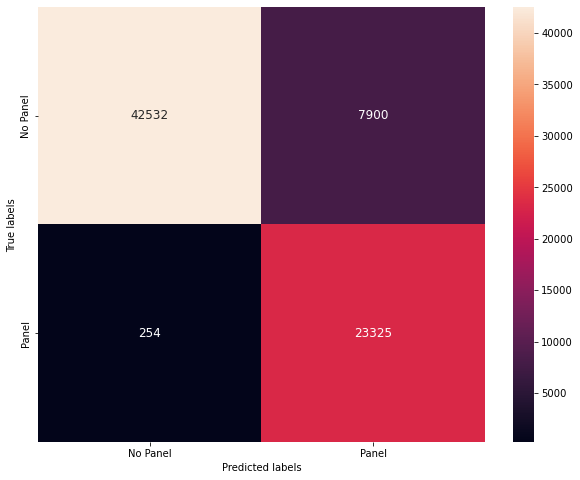

In [37]:
axis_label2=['No Panel','Panel']

cm2=confusion_matrix(y_true2,y_pred2_label)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm2,annot_kws={"size": 12},annot=True,fmt='.0f',xticklabels=axis_label2, yticklabels=axis_label2)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('/home/jianhaozhang/Capstone/Model/Group2/Confusion_Matrix2.png')

In [81]:
print(classification_report(y_true2,y_pred2_label))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     50432
           1       0.75      0.99      0.85     23579

    accuracy                           0.89     74011
   macro avg       0.87      0.92      0.88     74011
weighted avg       0.92      0.89      0.89     74011



## Group3 

In [38]:
model3=keras.models.load_model('/home/jianhaozhang/Capstone/Model/Group3')
pre_group3=preprocessing(group3)
y_true3=list(pre_group3.label_encode)
test3=data_generator(pre_group3)

In [39]:
y_pred3=model3.predict(test3)

In [40]:
y_pred3_label=np.argmax(y_pred3, axis=1)

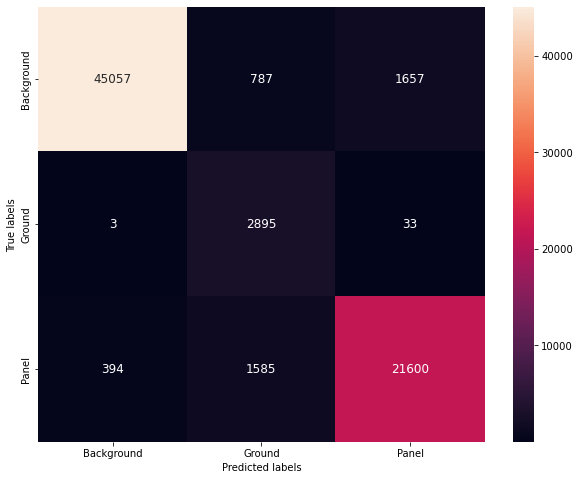

In [43]:
axis_label3=['Background','Ground','Panel']

cm3=confusion_matrix(y_true3,y_pred3_label)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm3,annot_kws={"size": 12},annot=True,fmt='.0f',xticklabels=axis_label3, yticklabels=axis_label3)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('/home/jianhaozhang/Capstone/Model/Group3/Confusion_Matrix3.png')

In [47]:
print(classification_report(y_true3,y_pred3_label))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     47501
           1       0.55      0.99      0.71      2931
           2       0.93      0.92      0.92     23579

    accuracy                           0.94     74011
   macro avg       0.82      0.95      0.87     74011
weighted avg       0.95      0.94      0.94     74011



## Group4 

In [44]:
model4=keras.models.load_model('/home/jianhaozhang/Capstone/Model/Group4')
pre_group4=preprocessing(group4)
y_true4=list(pre_group4.label_encode)
test4=data_generator(pre_group4)

In [45]:
y_pred4=model4.predict(test4)

In [46]:
y_pred4_label=np.argmax(y_pred4, axis=1)

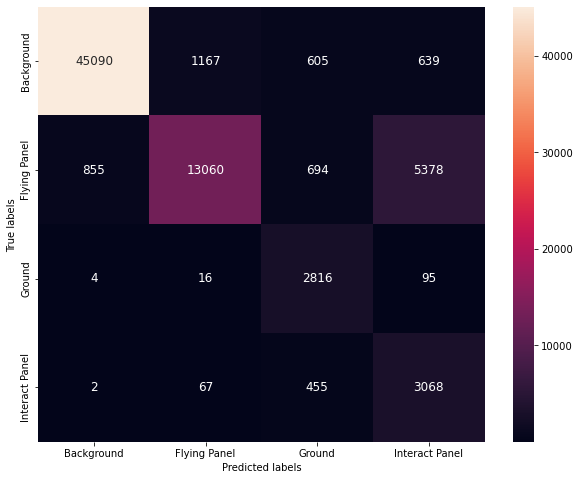

In [48]:
axis_label4=['Background','Flying Panel','Ground','Interact Panel']

cm4=confusion_matrix(y_true4,y_pred4_label)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm4,annot_kws={"size": 12},annot=True,fmt='.0f',xticklabels=axis_label4, yticklabels=axis_label4)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('/home/jianhaozhang/Capstone/Model/Group4/Confusion_Matrix4.png')

In [54]:
print(classification_report(y_true4,y_pred4_label))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     47501
           1       0.91      0.65      0.76     19987
           2       0.62      0.96      0.75      2931
           3       0.33      0.85      0.48      3592

    accuracy                           0.87     74011
   macro avg       0.71      0.85      0.74     74011
weighted avg       0.92      0.87      0.88     74011



## Full Label

In [32]:
model6=keras.models.load_model('/home/jianhaozhang/Capstone/Model/Group6')
pre_group6=preprocessing(group6)
y_true6=list(pre_group6.label_encode)
test6=data_generator(pre_group6)

In [50]:
y_pred6=model6.predict(test6)

In [51]:
y_pred6_label=np.argmax(y_pred6, axis=1)

In [52]:
pre_group6[['Label','label_encode']].groupby(['Label','label_encode']).count()

,
Label,label_encode
Flying over other backgrounds,0
Flying over reflection,1
Flying over sky,2
Flying under solar panel,3
Flying with ground,4
Flying with solar panel,5
Sit in background,6
Sit on panel,7
Sit on the ground,8


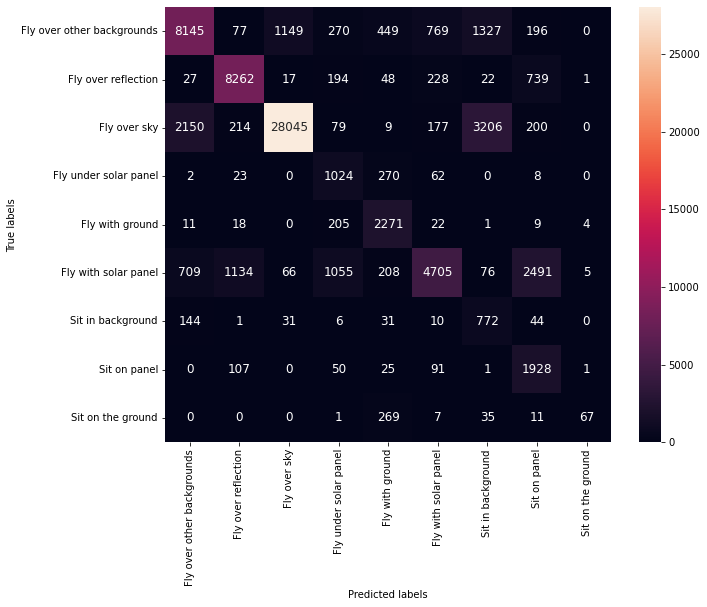

In [54]:
axis_label6=['Fly over other backgrounds','Fly over reflection','Fly over sky','Fly under solar panel'
            ,'Fly with ground','Fly with solar panel','Sit in background','Sit on panel','Sit on the ground']

cm6=confusion_matrix(y_true6,y_pred6_label)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm6,annot_kws={"size": 12},annot=True,fmt='.0f',xticklabels=axis_label6, yticklabels=axis_label6)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('/home/jianhaozhang/Capstone/Model/Group6/Confusion_Matrix6.png')

In [55]:
print(classification_report(y_true6,y_pred6_label))

              precision    recall  f1-score   support

           0       0.73      0.66      0.69     12382
           1       0.84      0.87      0.85      9538
           2       0.96      0.82      0.88     34080
           3       0.36      0.74      0.48      1389
           4       0.63      0.89      0.74      2541
           5       0.77      0.45      0.57     10449
           6       0.14      0.74      0.24      1039
           7       0.34      0.88      0.49      2203
           8       0.86      0.17      0.29       390

    accuracy                           0.75     74011
   macro avg       0.63      0.69      0.58     74011
weighted avg       0.83      0.75      0.77     74011



# 8. Unique label count and proportion in a track 

In [27]:
def prediction(data,model):
    full_label_test=preprocessing(data)[1]
    #Batch testing data
    test_data=data_generator(data)[1]
    
    #prediction
    y_pred=model.predict(test_data)
    y_pred=np.argmax(y_pred, axis=1)
    full_label_test['predicted_label']=list(y_pred)
    
    return full_label_test

In [28]:
#reverse the label enconding
def reverse_le(data):
    dic={}
    unique_label=data[['Label','label_encode']].groupby(['Label','label_encode']).count().reset_index()
    unique_label_num=list(unique_label.label_encode)
    unique_label_cat=list(unique_label.Label)
    
    for i in range(len(unique_label_num)):
        dic[unique_label_num[i]]=unique_label_cat[i]
    
    data['predicted_label']=data['predicted_label'].map(lambda x: dic[x])
    
    return data

In [29]:
# return track unique label count and proportion
def label_cnt_prop(data):
    summary=data.groupby(['obj_id','predicted_label']).size().reset_index(name='count')
    summary['%'] = round(100 * summary['count'] / summary.groupby('obj_id')['count'].transform('sum'),2)
    
    return summary

In [30]:
# put everything together
def label_prediction_summary(data,model):
    summary=prediction(data,model)
    summary=reverse_le(summary)
    summary=label_cnt_prop(summary)
    
    return summary

In [56]:
label_prediction_summary(group6,model6)

,obj_id,predicted_label,count,%
0,155,Flying over reflection,3,100.00
1,182,Sit in background,3,100.00
2,187,Flying over other backgrounds,2,33.33
3,187,Flying with solar panel,3,50.00
4,187,Sit on panel,1,16.67
...,...,...,...,...
607,48647,Flying over sky,2,100.00
608,48724,Flying over sky,1,100.00
609,48820,Flying over other backgrounds,13,76.47
610,48820,Flying over sky,4,23.53
